In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return x,y,z

def cart2pol(vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    r = np.linalg.norm(vec)
    tet = np.arccos(z/r)
    phi = np.arctan(y/x)
    return r, tet, phi

def r_ort(tet, phi):
    x = np.sin(tet)*np.cos(phi)
    y = np.sin(tet)*np.sin(phi)
    z = np.cos(tet)
    return np.array([x, y, z])

def tet_ort(tet, phi):
    x = np.cos(tet)*np.cos(phi)
    y = np.cos(tet)*np.sin(phi)
    z = -np.sin(tet)
    return np.array([x, y, z])

def phi_ort(tet, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x, y, z])


In [3]:
class Material:
    def __init__(self, Ms, gamma=5e8, alpha=0.018, Hkeff=6100.0):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Hkeff = Hkeff


def StonerWohlfarth_Heff(M, Hkeff):
    Mx, My, Mz = M
    x = -0.5*Hkeff*Mx*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
    y = -0.5*Hkeff*My*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
    z = Hkeff*Mz*(1.0*Mx**2 + 1.0*My**2 + 0.5*Mz**2)/(Mx**2 + My**2 + Mz**2)**(3/2)
    
    return np.array([x, y, z])


In [4]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class LLG_EQ:
    def __init__(self):
        S = CoordSys3D('S')
        
        x, y, z = symbols('x y z')
        dMdt = x*S.i + y*S.j + z*S.k
        
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        Hx, Hy, Hz = symbols('Hx Hy Hz')
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        g = sym.Symbol('g')
        a = sym.Symbol('a')
        Ms = sym.Symbol('Ms')
        
        vec_eq = -dMdt - g*M.cross(H)+(a/Ms)*(M.cross(dMdt))
        sol = sym.solve(vec_eq.to_matrix(S), dMdt.to_matrix(S))
        
        sol[x] = simplify(sol[x])
        sol[y] = simplify(sol[y])
        sol[z] = simplify(sol[z])
        
        self.sol_lamb = dict()
        lambda_var_set = (
            a, g, Ms, 
            Mx, My, Mz, 
            Hx, Hy, Hz)
        
        self.sol_lamb['x'] = lambdify(lambda_var_set, sol[x], 'numpy')
        self.sol_lamb['y'] = lambdify(lambda_var_set, sol[y], 'numpy')
        self.sol_lamb['z'] = lambdify(lambda_var_set, sol[z], 'numpy')
        
        symbs = [x, y, z]
        dsymbs = [Mx, My, Mz]
        self.jac_mat = []
        for i in range(3):
            jac_row = []
            for j in range(3):
                jac_row.append(
                    lambdify(
                        lambda_var_set, 
                        simplify(sol[symbs[i]].diff(dsymbs[j]))
                    )
                )
            self.jac_mat.append(jac_row)
    
    def right_hand(self, Heff, M, film):
        x = self.sol_lamb['x'](
            film.alpha, film.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        y = self.sol_lamb['y'](
            film.alpha, film.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        z = self.sol_lamb['z'](
            film.alpha, film.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        return [x, y, z]
    
    def jacobian(self, M, Heff, film):
        ret = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                ret[i][j] = self.jac_mat[i][j](
                    film.alpha, film.gamma, np.linalg.norm(M),
                    M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
                )
        return ret
             
    


In [5]:
mu0 = 1.2566370621219e-6
film = Material(1042e3, gamma=1.76e11*mu0, alpha=0, Hkeff=0)
equation = LLG_EQ()

Hext = np.array(pol2cart(1042e3, np.deg2rad(0.0), 0.0))


def Heff_function(M, film):
    return Hext #+ StonerWohlfarth_Heff(M, film.Hkeff)

def Jacobian(t, M):
    Heff = Heff_function(M, film)
    return equation.jacobian(M, Heff, film)

def model(t,M):
    Heff = Heff_function(M, film)
    return equation.right_hand(Heff, M, film)
    
M0 = pol2cart(film.Ms, np.deg2rad(5.0), 0)

time_span = [0.0, 1000.0e-12]
sol = solve_ivp(model, time_span, M0,t_eval=np.linspace(time_span[0], time_span[1],1000000), method = 'RK45', jac=Jacobian, max_step=1e-14)

df = pd.DataFrame()
df['t'] = sol.t
df['x'] = sol.y[0]
df['y'] = sol.y[1]
df['z'] = sol.y[2]
df['r'] = np.sqrt(df['x']**2+df['y']**2+df['z']**2)
df

c:\users\sasha\appdata\local\programs\python\python38\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  warn("The following arguments have no effect for a chosen solver: {}."


,t,x,y,z,r
0,0.000000e+00,90816.283943,0.000000,1.038035e+06,1042000.0
1,1.000001e-15,90816.281531,20.929286,1.038035e+06,1042000.0
2,2.000002e-15,90816.274296,41.858571,1.038035e+06,1042000.0
3,3.000003e-15,90816.262238,62.787853,1.038035e+06,1042000.0
4,4.000004e-15,90816.245357,83.717132,1.038035e+06,1042000.0
...,...,...,...,...,...
999995,9.999960e-10,-39567.178874,-81743.720157,1.038035e+06,1042000.0
999996,9.999970e-10,-39548.339377,-81752.836536,1.038035e+06,1042000.0
999997,9.999980e-10,-39529.497780,-81761.948573,1.038035e+06,1042000.0
999998,9.999990e-10,-39510.654083,-81771.056268,1.038035e+06,1042000.0


<AxesSubplot:xlabel='t'>

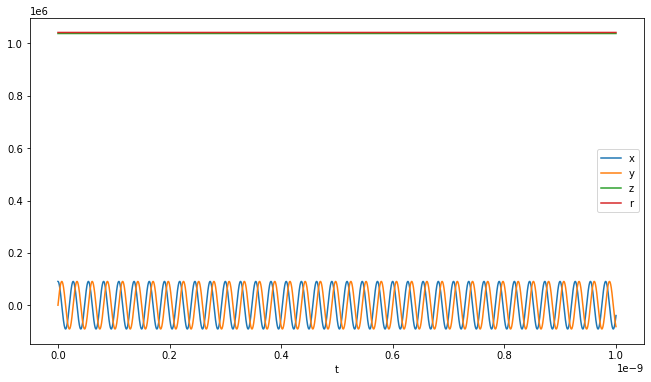

In [6]:
#### %matplotlib inline
%matplotlib inline
#%matplotlib qt

df.plot('t', figsize = (11, 6))

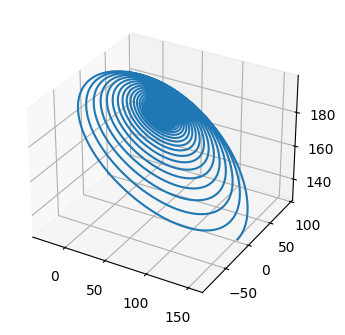

In [12]:
#%matplotlib inline
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

36.67840002002229


<IPython.core.display.Javascript object>


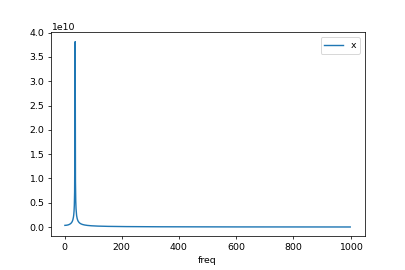

,freq,x,y,z
0,0.999999,3.554334e+08,5.658949e+08,0.0
1,1.999998,3.572335e+08,5.674096e+08,0.0
2,2.999997,3.602453e+08,5.699488e+08,0.0
3,3.999996,3.644868e+08,5.735354e+08,0.0
4,4.999995,3.699842e+08,5.782017e+08,0.0
...,...,...,...,...
994,994.999005,2.087586e+07,1.312057e+07,0.0
995,995.999004,2.085484e+07,1.310732e+07,0.0
996,996.999003,2.083385e+07,1.309409e+07,0.0
997,997.999002,2.081291e+07,1.308089e+07,0.0


In [7]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x','y','z'])

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[1:1000] * 1e-9

column_names = ['x','y','z']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[1:1000]


print(np.linalg.norm(Hext)*film.gamma/(2*np.pi)*1e-9)
freq_df.plot(x='freq', y='x')
freq_df

# legacy code

In [ ]:
def LLG(Heff, M, film):
    Ms = np.linalg.norm(M)
    
    first = np.cross(M, Heff)
    second = (film.alpha/Ms)*np.cross(M, np.cross(M, Heff))
    
    return -(film.gamma/(1+film.alpha**2))*(first + second)

In [ ]:
def StonerWohlfarth_Heff(M, Hkeff):
    M_abs, M_tet, M_phi = cart2pol(M)
    
    r = 0.5*Hkeff*(np.cos(M_tet)**2)
    tet = -0.5*Hkeff*np.sin(2.0*M_tet)
    
    return r*r_ort(M_tet, M_phi) + tet*tet_ort(M_tet, M_phi)

In [6]:
S = CoordSys3D('S')

Hkeff = symbols("Hkeff")
Mx, My, Mz = symbols("Mx My Mz")
M = Mx*S.i + My*S.j + Mz*S.k

Esh = -0.5*(Hkeff/M.magnitude())*((M.dot(S.k))**2)
print(Esh)
print()

Heff = [-Esh.diff(Mx), -Esh.diff(My), -Esh.diff(Mz)]
for i in range(3):
    print(simplify(Heff[i]))

-0.5*Hkeff*Mz**2/sqrt(Mx**2 + My**2 + Mz**2)

-0.5*Hkeff*Mx*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
-0.5*Hkeff*My*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
Hkeff*Mz*(1.0*Mx**2 + 1.0*My**2 + 0.5*Mz**2)/(Mx**2 + My**2 + Mz**2)**(3/2)


<IPython.core.display.Javascript object>


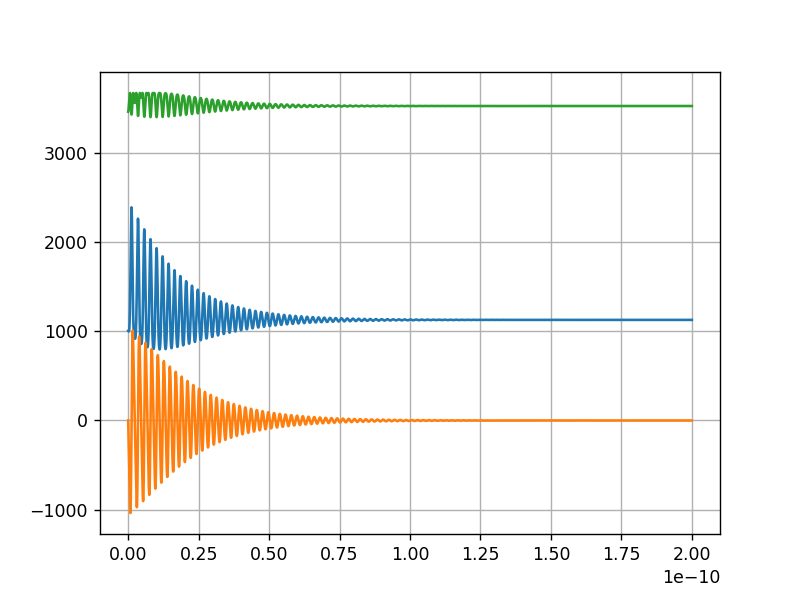

In [18]:
%matplotlib notebook

heff = [];
for i in range(len(sol.t)):
    heff.append(Heff_function(sol.y.T[i], film))

heff = np.array(heff).T

#ax.plot(heff[0], heff[1], heff[2])
plt.grid(True)
plt.plot(sol.t, heff[0])
plt.plot(sol.t, heff[1])
plt.plot(sol.t, heff[2])

<IPython.core.display.Javascript object>


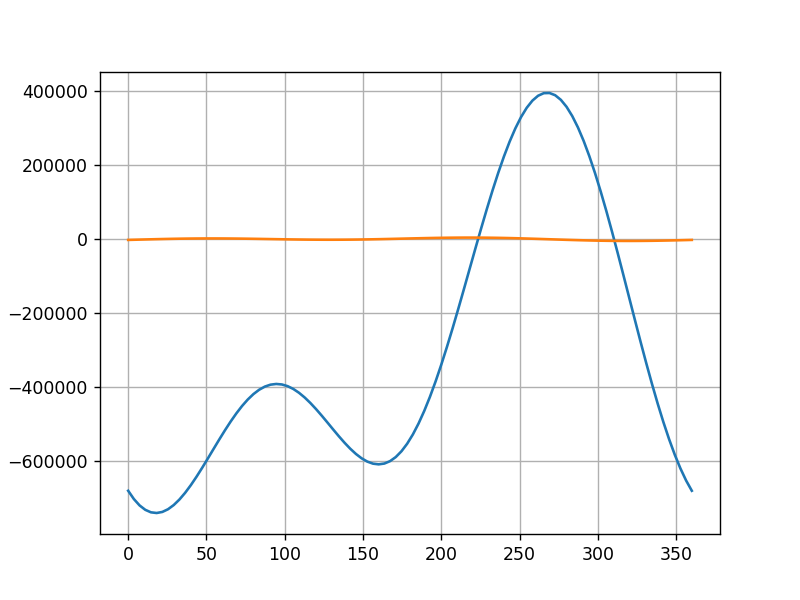

In [17]:
%matplotlib notebook
Hkeff_here = 6100.0
def F(Hext, M, tet):
    H_abs, H_tet, H_phi = cart2pol(Hext)
    M_abs, M_tet, M_phi = cart2pol(M)
    return -M_abs*H_abs*np.cos(H_tet - tet) - 0.5*M_abs*Hkeff_here*(np.cos(tet)**2)
    
def dF(Hext, M, tet):
    H_abs, H_tet, H_phi = cart2pol(Hext)
    M_abs, M_tet, M_phi = cart2pol(M)
    return 0.5*Hkeff_here*np.sin(2*tet) - H_abs*np.sin(H_tet - tet)
    
x = np.linspace(0,2*np.pi, 100)
y = []
y2 = []

Hext_here = np.array(pol2cart(2000.0, np.deg2rad(80.0), 0.0))
M0_here = np.array(pol2cart(200.0, np.deg2rad(80.0), 0.0))
for i in range(len(x)):
    y.append(F(Hext_here, M0_here, x[i]))
    y2.append(dF(Hext_here, M0_here, x[i]))

y = np.array(y)
plt.plot(np.rad2deg(x), y)
plt.plot(np.rad2deg(x), y2)
plt.grid()